In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
model.eval()

Using cache found in C:\Users\inesp/.cache\torch\hub\pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
data_transforms = {
    'Training Tiny': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Val Tiny': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/inesp/Documents/3A Inès/Deep Learning/Projet/Paris'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training Tiny', 'Val Tiny']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Training Tiny', 'Val Tiny']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training Tiny', 'Val Tiny']}
class_names = image_datasets['Training Tiny'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(image_datasets)
# print(class_names)
print(iter(dataloaders))

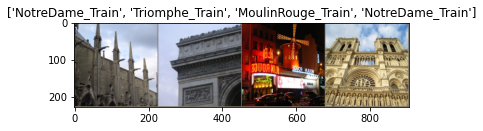

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Training Tiny']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training Tiny', 'Val Tiny']:
            if phase == 'Training Tiny':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]: #depends on the number of batches chosen
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training Tiny'): #sets gradient calculations to on or off
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # training_loss.append(loss)

                    # backward + optimize only if in training phase
                    if phase == 'Training Tiny':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Training Tiny':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'Training Tiny':
                training_loss.append(epoch_loss)
            else:
                validation_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Val Tiny' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    print('validation loss: ' + str(validation_loss))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plt.plot(training_loss, 'b', label='Training Loss')
    plt.plot(validation_loss, 'r', label='Validation Loss')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [48]:
num_classes = 11
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

for name, child in model_ft.named_children():
    for name2, params in child.named_parameters():
        # print(name, name2)
        pass

for param in model.parameters():
    param.requires_grad = True

ct = 0
for name, child in model_ft.named_children():
    # ct += 1
    # if ct < 4:
    #     for name2, params in child.named_parameters():
    #         params.requires_grad = False
    for name2, params in child.named_parameters():
            # print(name+name2)
            if 'layer4' not in name+name2 and 'fc' not in name:
                params.requires_grad = False

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

model_ft = model_ft.to(device)


Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [45]:
# feature_extract = True
# num_classes = 11

# model_ft = models.resnet18(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract)
# num_ftrs = model_ft.fc.in_features
# model_ft.fc = nn.Linear(num_ftrs, num_classes)

# model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# params_to_update = model_ft.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/24
----------
Training Tiny Loss: 2.3125 Acc: 0.1899
Val Tiny Loss: 1.4836 Acc: 0.5060
Epoch 1/24
----------
Training Tiny Loss: 1.6127 Acc: 0.4652
Val Tiny Loss: 1.2368 Acc: 0.5783
Epoch 2/24
----------
Training Tiny Loss: 1.3102 Acc: 0.5886
Val Tiny Loss: 1.1395 Acc: 0.6988
Epoch 3/24
----------
Training Tiny Loss: 1.1611 Acc: 0.6392
Val Tiny Loss: 1.1269 Acc: 0.7470
Epoch 4/24
----------
Training Tiny Loss: 1.0845 Acc: 0.6677
Val Tiny Loss: 1.1911 Acc: 0.6627
Epoch 5/24
----------
Training Tiny Loss: 0.8430 Acc: 0.7563
Val Tiny Loss: 1.1369 Acc: 0.7229
Epoch 6/24
----------
Training Tiny Loss: 0.8495 Acc: 0.7247
Val Tiny Loss: 1.1609 Acc: 0.7229
Epoch 7/24
----------
Training Tiny Loss: 0.7012 Acc: 0.8006
Val Tiny Loss: 1.1031 Acc: 0.7108
Epoch 8/24
----------
Training Tiny Loss: 0.7229 Acc: 0.8038
Val Tiny Loss: 1.0765 Acc: 0.7229
Epoch 9/24
----------
Training Tiny Loss: 0.7749 Acc: 0.7595
Val Tiny Loss: 1.0831 Acc: 0.7229
Epoch 10/24
----------
Training Tiny Loss: 0.7557 

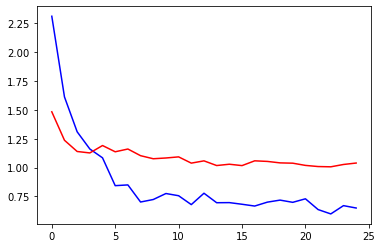

In [46]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler)

In [3]:
# load
pretrained_dict = torch.load('C:/Users/inesp/Documents/3A Inès/Deep Learning/Projet/Projet DL Github/ResNet101_Oxford.pt', map_location='cpu')
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
model_dict = model.state_dict()
# 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in model_dict) and (model_dict[k].shape == pretrained_dict[k].shape)}
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
# 3. load the new state dict
model.load_state_dict(model_dict)

# for name, child in model.named_children():
#     for name2, params in child.named_parameters():
#         print(name, name2)


Using cache found in C:\Users\inesp/.cache\torch\hub\pytorch_vision_v0.6.0


<All keys matched successfully>

In [57]:
data_transforms = {'Test Tiny': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:/Users/inesp/Documents/3A Inès/Deep Learning/Projet/Paris'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Test Tiny']}
dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=11,
                                             shuffle=True, num_workers=4)
              for x in ['Test Tiny']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print(iter(dataloaders_test))
# print(dataloaders_test['Test Tiny'])
#print(inputs)
for inputs, labels in dataloaders_test['Test Tiny']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # print(inputs.size())
    #print(labels)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    #print(preds)
    print(preds == labels)

tensor([False, False, False, False, False, False, False, False, False, False,
        False])
tensor([False, False, False, False, False, False, False, False, False, False,
        False])
tensor([False, False, False, False, False, False, False, False, False, False,
        False])


In [ ]:
def loading_saved_model():
    model_ft = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=True)
    model_ft.eval()
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,11)

    model_ft.load_state_dict(torch.load('Models/VGG16_tiny_50.pt', map_location='cpu'))
    model_ft.eval()
    return model_ft

def getting_the_test_data():

    data_transforms = {'Test Tiny': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    data_dir = 'Paris'

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                    for x in ['Test Tiny']}
    dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=11,
                                                shuffle=True, num_workers=4)
                for x in ['Test Tiny']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['Test Tiny']}
    class_names = image_datasets['Test Tiny'].classes

    Total_size = dataset_sizes['Test Tiny']
    return dataloaders_test, class_names, Total_size

def getting_predictions(dataloaders_test, model_ft):
    inputs_list = []
    labels_list = []
    for inputs, labels in dataloaders_test['Test Tiny']:
        labels_list += labels.tolist()
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        inputs_list += preds.tolist()

    return np.array(inputs_list), np.array(labels_list)

def computing_accuracy(inputs_list, labels_list, class_names, Total_size):
    accuracies = {}
    acc_total = 0
    for i in range(11):
        labels_index = np.where(labels_list == i)[0]
        acc = 0
        for j in labels_index:
            if inputs_list[j] == labels_list[j]:
                acc += 1
        acc_total += acc
        accuracies[class_names[i]] = acc/len(labels_index)
    accuracies['Total'] = acc_total/Total_size
    return accuracies

def main():

    # Loading the model
    model_ft = loading_saved_model()

    # Getting the data
    dataloaders_test, class_names, Total_size = getting_the_test_data()

    # Pridicting landmarks
    inputs_list, labels_list = getting_predictions(dataloaders_test, model_ft)

    # Computing the accuracy
    accuracy = computing_accuracy(inputs_list, labels_list, class_names, Total_size)

    return accuracy

accuracy = main()
print(accuracy)

In [13]:
torch.save(model_ft.state_dict(),"state_dict_model_ResNet18.pt")